In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import functions as ff
#import newfunctions as nff
#import functionsDt1 as dff

from darts import TimeSeries as ts 
from darts import concatenate

from sklearn.metrics import mean_absolute_error,r2_score

from scipy.stats import friedmanchisquare

import scikit_posthocs as sp

import pickle
import warnings
warnings.filterwarnings("ignore")

#working from py file results in error due to tsfresh extract_features so we make pipeline in notebook
#to reload all changed modules every time before executing a new line
%load_ext autoreload
%autoreload 2

In [2]:
import os
fileList = os.listdir();
fileList = [i for i in fileList if ('.pickle' in i)&('Cost' in i)]; fileList

['maeCost_24x1_const020x30_len780_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_constA20x30_len513_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_constM20x30_len640_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_ensemble_mean_fromData_len366_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_ensemble_median_fromData_len364_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_Sel_rollingFalse_ValFalse_len286_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_Sel_rollingFalse_ValTrue_len303_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_Sel_rollingTrue_ValFalse_len599_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_Sel_rollingTrue_ValTrue_len330_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_TSFresh_rollingFalse_ValFalse_len599_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_TSFresh_rollingFalse_ValTrue_len599_par0.2_bExtra0.07_sExtra-0.

In [3]:
pickle.load(open(fileList[0], "rb")).keys()

dict_keys(['costOpt', 'mae', 'costDef', 'costNoBat', 'params', 'idx', 'trainTestInfo', 'eics'])

In [4]:
a ={}
for filename in fileList:
    d=pickle.load(open(filename, "rb"))
    cols = {i:d[i] for i in {i for i in d if 'params' not in i}}
    algo1 = filename.split('maeCost_24x1_')[1].split('_len')[0]
    algoRegr = algo1.split('20x30')[0]
    if len(algoRegr) == 2: 
        algo1 = algoRegr.lower()
        algo1 = algo1 + ' 1m'
    
    try: algo2 = filename.split('20x30_')[1].split('len')[0]
    except: 1
    if len(algo2)==0: algo = algoRegr
    if 'rolling' in algo2:
        algo2 = algo2.replace('Sel','autofeat')
        algo2 = algo2.replace('TSFresh','tsfresh')
        algo2 = algo2.replace('Val','bestVal')
        algo2 = algo2.replace('True','T')
        algo2 = algo2.replace('False','F')
        algo2 = algo2.replace('bestValT','') #default dont show anything
        algo=algo1+'_'+algo2
    if 'fromData' in algo1: 
        algo = algo1.split('.csv')[0].replace('fromData','').replace('.','')[:-1] 
        algo = algo.replace('_mean','A')
        algo = algo.replace('_median','M')
        algo = algo.replace('_nonuniform','')
        algo = algo.replace('Hours',' hour')
    algo = algo.replace('_',' ').strip()
    a[algo] = pd.DataFrame(cols).rename(columns={'costOpt':'cost'})    

In [5]:
cols = ['cost','mae','eics','idx']

results = pd.DataFrame()
for i,df in enumerate(a):
    dd = a[df][cols].set_index(['eics','idx']).rename(mapper = lambda x: x+': '+df, axis='columns')
    if i == 0: results = dd
    else: results = pd.concat([dd,results],axis=1,join='inner')
#results = results.dropna(axis=0)

In [6]:
results.shape

(181, 32)

In [7]:
results.isna().sum().sum()

0

In [8]:
results.columns

Index(['cost: oracle', 'mae: oracle', 'cost: gb 1m uku rollingT',
       'mae: gb 1m uku rollingT', 'cost: gb 1m uku rollingT bestValF',
       'mae: gb 1m uku rollingT bestValF', 'cost: gb 1m tsfresh rollingT',
       'mae: gb 1m tsfresh rollingT', 'cost: gb 1m tsfresh rollingT bestValF',
       'mae: gb 1m tsfresh rollingT bestValF', 'cost: gb 1m tsfresh rollingF',
       'mae: gb 1m tsfresh rollingF', 'cost: gb 1m tsfresh rollingF bestValF',
       'mae: gb 1m tsfresh rollingF bestValF', 'cost: gb 1m autofeat rollingT',
       'mae: gb 1m autofeat rollingT',
       'cost: gb 1m autofeat rollingT bestValF',
       'mae: gb 1m autofeat rollingT bestValF',
       'cost: gb 1m autofeat rollingF', 'mae: gb 1m autofeat rollingF',
       'cost: gb 1m autofeat rollingF bestValF',
       'mae: gb 1m autofeat rollingF bestValF', 'cost: ensembleM',
       'mae: ensembleM', 'cost: ensembleA', 'mae: ensembleA', 'cost: constM',
       'mae: constM', 'cost: constA', 'mae: constA', 'cost: const0',


In [9]:
results['cost: ensemble limit'] = results[[i for i in results.columns if 'cost: gb 1m autofeat' in i]].min(axis=1)
results

cost: oracle  \
eics                             idx                                 
B7B6B96D8CA1E97B16B47F51F58B6A6B 2021-12-22 00:00:00     19.527044   
                                 2021-07-10 06:00:00      0.823012   
                                 2021-04-11 17:00:00      2.380041   
                                 2021-06-02 04:00:00      6.952895   
                                 2021-06-08 02:00:00      1.100951   
...                                                            ...   
B7B6B96D8CA1E97B0A7628046D7E2ED3 2021-08-19 21:00:00      0.574661   
                                 2021-11-25 13:00:00      0.205535   
                                 2021-05-29 16:00:00      0.730666   
B7B6B96D8CA1E97B4D51F3D61DFEA629 2021-07-10 06:00:00     -0.189514   
                                 2021-06-26 01:00:00      1.020228   

                                                      mae: oracle  \
eics                             idx                                
B7B6B96D8CA1E97B16B47F51F58B6A6B 2021-12-22 00:00:00          0.0   
                                 2021-07-10 06:00:00          0.0   
                                 2021-04-11 17:00:00          0.0   
                                 2021-06-02 04:00:00          0.0   
                                 2021-06-08 02:00:00          0.0   
...                                                           ...   
B7B6B96D8CA1E97B0A7628046D7E2ED3 2021-08-19 21:00:00          0.0   
                                 2021-11-25 13:00:00          0.0   
                                 2021-05-29 16:00:00          0.0   
B7B6B96D8CA1E97B4D51F3D61DFEA629 2021-07-10 06:00:00          0.0   
                                 2021-06-26 01:00:00          0.0   

                                                      cost: gb 1m uku rollingT  \
eics                             idx                                             
B7B6B96D8CA1E97B16B47F51F58B6A6B 2021-12-22 00:00:00                 19.887932   
                                 2021-07-10 06:00:00                  0.995130   
                                 2021-04-11 17:00:00                  2.577968   
                                 2021-06-02 04:00:00                  7.210423   
                                 2021-06-08 02:00:00                  1.484349   
...                                                                        ...   
B7B6B96D8CA1E97B0A7628046D7E2ED3 2021-08-19 21:00:00                  0.762938   
                                 2021-11-25 13:00:00                  0.363823   
                                 2021-05-29 16:00:00                  0.802165   
B7B6B96D8CA1E97B4D51F3D61DFEA629 2021-07-10 06:00:00                 -0.051656   
                                 2021-06-26 01:00:00                  1.227054   

                                                      mae: gb 1m uku rollingT  \
eics                             idx                                            
B7B6B96D8CA1E97B16B47F51F58B6A6B 2021-12-22 00:00:00                 1.056602   
                                 2021-07-10 06:00:00                 0.189681   
                                 2021-04-11 17:00:00                 0.398826   
                                 2021-06-02 04:00:00                 1.554301   
                                 2021-06-08 02:00:00                 0.345400   
...                                                                       ...   
B7B6B96D8CA1E97B0A7628046D7E2ED3 2021-08-19 21:00:00                 0.177451   
                                 2021-11-25 13:00:00                 0.150773   
                                 2021-05-29 16:00:00                 0.290610   
B7B6B96D8CA1E97B4D51F3D61DFEA629 2021-07-10 06:00:00                 0.173923   
                                 2021-06-26 01:00:00                 0.354989   

                                                      cost: gb 1m uku rollingT bestValF  \
eics                             

In [10]:
results_mean = results.mean(axis=0).to_frame().T.assign(name='mean').set_index('name').rename_axis(None)
results_median = results.median(axis=0).to_frame().T.assign(name='median').set_index('name').rename_axis(None)
meanMedian = pd.concat([results_mean,results_median],axis=0)

H0 is rejected! Algorithms perform differently.  
Next we utilize post-hoc Nemenyi Test to find the best-performing algorithm. Nemenyi test compares algorithms pairwise and returns the p-values for each pairwise comparison of means. This can be used to find the groups of algos that differ after Friedman statistical test.

In [11]:
algos = [i for i in a]; algos

['const0',
 'constA',
 'constM',
 'ensembleA',
 'ensembleM',
 'gb 1m autofeat rollingF bestValF',
 'gb 1m autofeat rollingF',
 'gb 1m autofeat rollingT bestValF',
 'gb 1m autofeat rollingT',
 'gb 1m tsfresh rollingF bestValF',
 'gb 1m tsfresh rollingF',
 'gb 1m tsfresh rollingT bestValF',
 'gb 1m tsfresh rollingT',
 'gb 1m uku rollingT bestValF',
 'gb 1m uku rollingT',
 'oracle']

This can be plotted as follows by finding average ranks of the algorithms and unifying algorithms by means of critical distance (critical distance plot)

In [12]:
def plotCD(data,algos,metric,size=12,left = 5,filename=None):
    plt.rcParams.update({'font.size': size})

    dd = data.rank(axis=1).mean(axis=0).sort_values() #data with sorted averaged ranks: larger rank means larger error
    meanRanks, methods = dd.values, dd.index.values
    methodsPure = [i.split(': ')[1] for i in methods]
    
    plt.axhline(0,c='k')
    for i in np.arange(int(meanRanks.min()),int(meanRanks.max())+2):
        plt.plot([i,i],[-0.05,0.05],c='k')
        plt.text(i-0.04,0.08,f'{i}')
    plt.ylim(-2.5,0.6)
    plt.axis('off')
    #plot data
    colors = ['r','g','b','y','c','m','y']
    colors += colors + colors + colors+colors+ colors+colors
    
    for i,r in enumerate(meanRanks):
        if i<left: #these algoes are named to left
            y = -0.3-i*0.15
            plt.plot([min(meanRanks)-0.2,r],[y,y],c=colors[i]) #vertical market
            plt.text(min(meanRanks)-0.2,y,f'{methodsPure[i]}', horizontalalignment='right',c=colors[i]) #shift x coordinate of text to avoid overlapping
        else: 
            y = -0.3-(len(meanRanks)-1-i)*0.15
            plt.plot([max(meanRanks)+0.2,r],[y,y],c=colors[i])
            plt.text(max(meanRanks)+0.2,y,f'{methodsPure[i]}', horizontalalignment='left',c=colors[i]) #shift x coordinate of text to avoid overlapping
        plt.plot([r,r],[0,y],c=colors[i]) #horizontal marker
#critical distance (CD) for Nemeyi test from https://kourentzes.com/forecasting/2014/05/01/critical-values-for-the-nemenyi-test/
    K = len(methods) #number of models
    N = data.shape[0] #number of measurements
    qdata = pd.read_csv('nemenyi.csv')
    q = qdata[qdata['# models']==K]['Nemenyi 0.05'].values[0]
    CD=q*np.sqrt(K*(K+1)/(6*N))  #number of models K=6, alpha=0.05
    x= np.mean(meanRanks)
    plt.plot([x,x+CD],[0.3,0.3],c='r',lw=3)
    plt.text(x,0.4,f'CD={CD:.3f}')
#plot pairwise pvalues
    pairwiseP = sp.posthoc_nemenyi_friedman(data.values)
    pairwiseP.columns, pairwiseP.index = data.columns, data.columns  #rename columns and index
    for m in methods:
        pvalues = pairwiseP[m]
        for mm in pvalues.index.values:
            if (pvalues[mm]>0.05)&(meanRanks[np.where(methods==m)[0][0]]!=meanRanks[np.where(methods==mm)[0][0]]):
                #print(m,mm,pvalues[mm])
                plt.plot([meanRanks[np.where(methods==m)[0][0]],meanRanks[np.where(methods==mm)[0][0]]],[-0.2,-0.2],c='k',lw=4)
    bestRank = data[[metric+': '+i for i in algos]].rank(axis=1).mean(axis=0).sort_values()[0]
    worstRank = data[[metric+': '+i for i in algos]].rank(axis=1).mean(axis=0).sort_values()[-1]
    plt.plot([bestRank,bestRank+CD],[-0.15,-0.15],c='r',lw=4)
    plt.plot([worstRank,worstRank-CD],[-0.25,-0.25],c='r',lw=4)
    plt.title(f'{metric[0].upper()+metric[1:]} mean rank and critical distance (CD)')
    if filename!=None: plt.savefig(f"{metric.replace(' ','_')}_cd"+filename+".eps", format='eps',dpi=200,bbox_inches='tight')
    return plt.show()

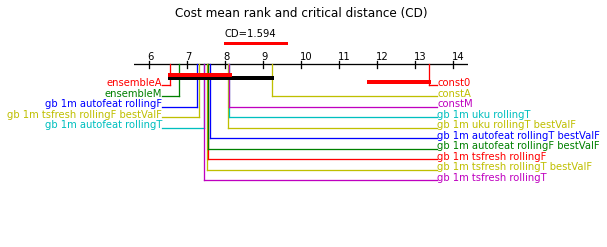

,cost: oracle,cost: ensembleA,cost: ensembleM,cost: gb 1m autofeat rollingF,cost: gb 1m autofeat rollingF bestValF,cost: gb 1m autofeat rollingT bestValF,cost: gb 1m autofeat rollingT,cost: gb 1m tsfresh rollingF bestValF,cost: gb 1m tsfresh rollingT,cost: gb 1m tsfresh rollingF,cost: gb 1m tsfresh rollingT bestValF,cost: constM,cost: gb 1m uku rollingT bestValF,cost: gb 1m uku rollingT,cost: constA,cost: const0
mean,1.586996,1.736392,1.737198,1.737206,1.739256,1.741622,1.742081,1.744182,1.745020,1.745313,1.745949,1.757392,1.762946,1.764116,1.782080,1.906615
median,0.495033,0.698788,0.690140,0.621127,0.665777,0.679005,0.692806,0.650048,0.650048,0.650048,0.650048,0.606429,0.693948,0.693948,0.658351,0.795094


In [13]:
metric = 'cost'
#algos = ['ensemble limit']+list(algos)

plotCD(results[[metric+': '+i for i in algos[:-1]]],algos[:-1],metric,left=5)
meanMedian[[metric+': '+i for i in algos]].sort_values(by='mean',axis=1)

In [14]:
resultsDelta = results.copy(deep=True)
for i in [i for i in resultsDelta.columns if 'cost' in i]:
    alg = i.split('cost: ')[1]
    resultsDelta['excess cost: '+alg] = resultsDelta[i] - resultsDelta['cost: oracle']

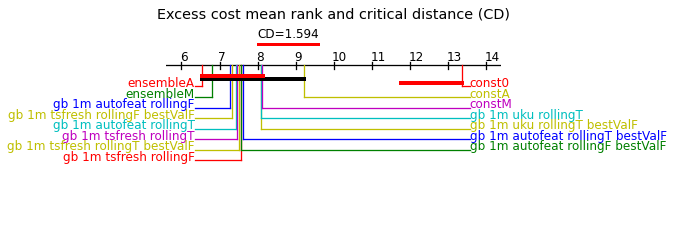

In [15]:
metric = 'excess cost'
plotCD(resultsDelta[[metric+': '+i for i in algos[:-1]]],algos[:-1],metric,left=8,filename='_EE_ens')
#meanMedian[[metric+'_'+i for i in algos]]

In [16]:
resultsDelta[[metric+': '+i for i in algos[:-1]]].mean(axis=0).sort_values()

excess cost: ensembleA                           0.149396
excess cost: ensembleM                           0.150202
excess cost: gb 1m autofeat rollingF             0.150210
excess cost: gb 1m autofeat rollingF bestValF    0.152260
excess cost: gb 1m autofeat rollingT bestValF    0.154626
excess cost: gb 1m autofeat rollingT             0.155085
excess cost: gb 1m tsfresh rollingF bestValF     0.157186
excess cost: gb 1m tsfresh rollingT              0.158024
excess cost: gb 1m tsfresh rollingF              0.158317
excess cost: gb 1m tsfresh rollingT bestValF     0.158953
excess cost: constM                              0.170397
excess cost: gb 1m uku rollingT bestValF         0.175950
excess cost: gb 1m uku rollingT                  0.177120
excess cost: constA                              0.195084
excess cost: const0                              0.319619
dtype: float64

In [17]:
resultsDelta['excess cost: ensemble limit'].mean()

0.1314206895259668